# Feature Dependence

### Import libraries and set plotting style

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import statsmodels.api as sm
from matplotlib.patches import Patch

sys.path.append('../scr')
from data_preprocessing import *
from analysis import *
from utils import *
from plot import *

 ### Feature Numbers and Model Types

In [2]:
feature_numbers = ['9', '22', '30']  
average_confidence = ['8','21']
model_types = ['LP','RP']  

### Load CSV files

In [3]:
df_predictions = load_and_clean_predictions('unemployment','predictions',feature_numbers, model_types, data_path='../predictions/')

Loaded file: ../predictions/unemployment_predictions_9LP_nodate.csv for model 9LP
Loaded file: ../predictions/unemployment_predictions_9RP_nodate.csv for model 9RP
Loaded file: ../predictions/unemployment_predictions_22LP_nodate.csv for model 22LP
Loaded file: ../predictions/unemployment_predictions_22RP_1128_0647.csv for model 22RP
Loaded file: ../predictions/unemployment_predictions_30LP_nodate.csv for model 30LP
Loaded file: ../predictions/unemployment_predictions_30RP_nodate.csv for model 30RP


In [4]:
df_confidence = load_and_clean_predictions('unemployment','average_confidence', average_confidence, model_types, data_path='../predictions/')

Loaded file: ../predictions/unemployment_average_confidence_8LP_1124_1658.csv for model 8LP
Loaded file: ../predictions/unemployment_average_confidence_8RP_1124_2308.csv for model 8RP
Loaded file: ../predictions/unemployment_average_confidence_21LP_1124_1705.csv for model 21LP
Loaded file: ../predictions/unemployment_average_confidence_21RP_1124_2328.csv for model 21RP


### Mean of Absolute Differences

\begin{align}
{\text{Mean of Absolute Differences}} = \frac{1}{N} \sum_{i=1}^{N} \left| M_i^{F_1, T}(x) - M_i^{F_2, T}(x) \right|
\text{,} \quad F_1 \neq F_2  \notag
\end{align}


In [7]:
model_types = ['LP', 'RP']

mean_of_abs_diff = {model_type: {} for model_type in model_types}
combined_mean_of_abs_diff = {}

for model_type in model_types:
    suffix = 'LM' if model_type == 'LP' else 'RM'

    substring_1_9vs30 = f'9{suffix}'  
    substring_2_9vs30 = f'30{suffix}'  
    substring_1_22vs30 = f'22{suffix}'  
    substring_2_22vs30 = f'30{suffix}' 

    mean_of_abs_diff[model_type]['abs_diff_9vs30'] = compute_row_stats(
        compute_absolute_difference(
            df_predictions['9'][model_type], 
            df_predictions['30'][model_type],
            substring_1=substring_1_9vs30, 
            substring_2=substring_2_9vs30
        )
    )['mean']
    
    mean_of_abs_diff[model_type]['abs_diff_22vs30'] = compute_row_stats(
        compute_absolute_difference(
            df_predictions['22'][model_type], 
            df_predictions['30'][model_type],
            substring_1=substring_1_22vs30, 
            substring_2=substring_2_22vs30
        )
    )['mean']

    combined_mean_of_abs_diff[model_type] = pd.concat([
        mean_of_abs_diff[model_type]['abs_diff_9vs30'].rename("abs_diff_9vs30"),
        mean_of_abs_diff[model_type]['abs_diff_22vs30'].rename("abs_diff_22vs30")
    ], axis=1)


In [8]:
# add ID column from confidence to combined_mean_of_abs_diff
for model_type in model_types:
    # extract ID column from confidence and reset the index in combined_mean_of_abs_diff
    combined_mean_of_abs_diff[model_type] = (
    df_confidence['8'][model_type][['ID']]  # extract ID column from df_confidence
    .join(combined_mean_of_abs_diff[model_type].reset_index(drop=True), rsuffix='_mean_abs_diff')
)
    
#print(combined_mean_of_abs_diff['LP'].head())

In [9]:
# add 'ID' column from confidence to combined_mean_of_abs_diff
for model_type in model_types:
    # extract ID column from confidence and reset the index in combined_mean_of_abs_diff
    combined_mean_of_abs_diff[model_type] = (
    df_confidence['21'][model_type][['ID']] # extract ID column from df_confidence
    .join(combined_mean_of_abs_diff[model_type].reset_index(drop=True), rsuffix='_mean_abs_diff')
)

#print(combined_mean_of_abs_diff['LP'].head()

### Correlation between Mean of Absolute Differences and Average Errors

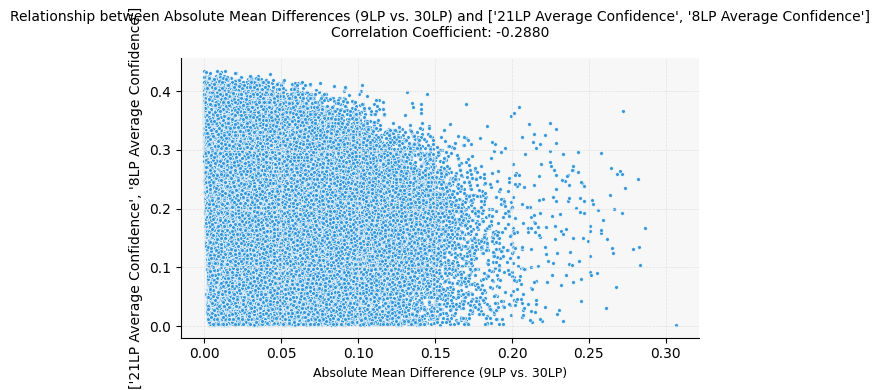

Model Type: LP, Comparison: 9LP vs. 30LP
Unmatched IDs for LP, 9LP vs. 30LP: set()


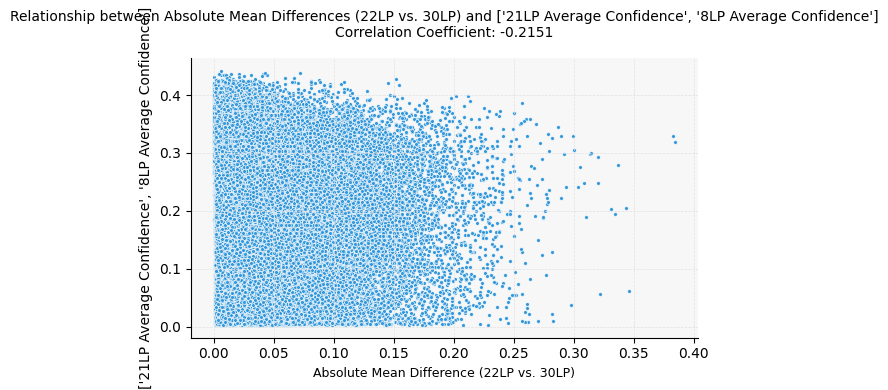

Model Type: LP, Comparison: 22LP vs. 30LP
Unmatched IDs for LP, 22LP vs. 30LP: set()


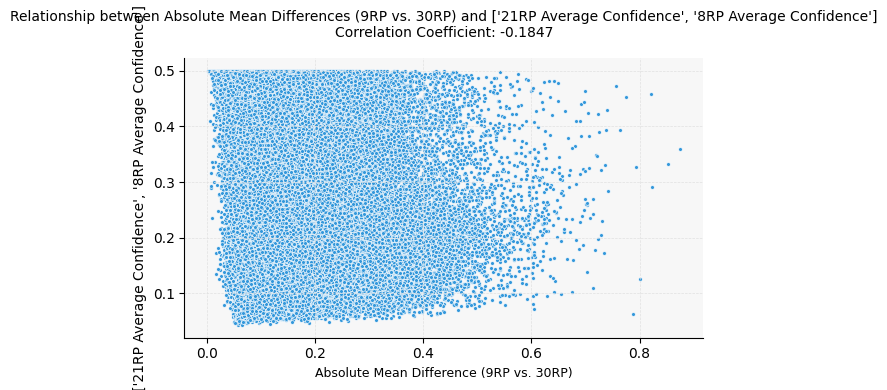

Model Type: RP, Comparison: 9RP vs. 30RP
Unmatched IDs for RP, 9RP vs. 30RP: set()


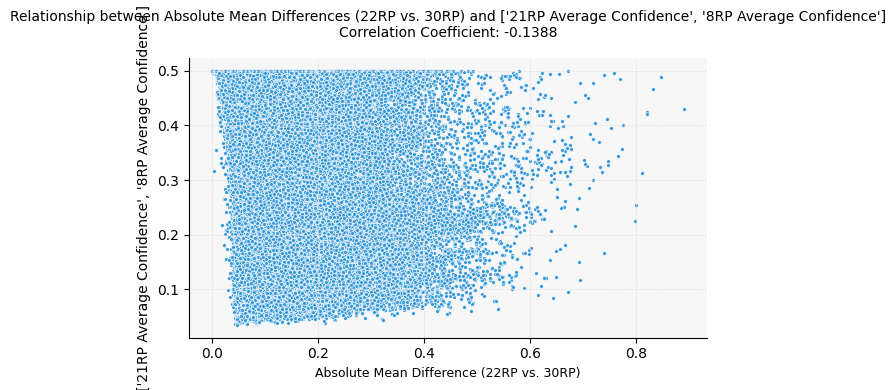

Model Type: RP, Comparison: 22RP vs. 30RP
Unmatched IDs for RP, 22RP vs. 30RP: set()


In [10]:
# Parameters for correlation analysis
feature_numbers = ['9', '22', '30']
model_types = ['LP', 'RP']

params = {
    'LP': {
        'comparison_labels': ['9LP vs. 30LP', '22LP vs. 30LP'],  
        'average_confidence_list': ['21', '8'],  
        'average_confidence_labels': ['21LP Average Confidence', '8LP Average Confidence'],
        'indices': ['9vs30', '22vs30']
    },
    'RP': {
        'comparison_labels': ['9RP vs. 30RP', '22RP vs. 30RP'], 
        'average_confidence_list': ['21', '8'], 
        'average_confidence_labels': ['21RP Average Confidence', '8RP Average Confidence'],
        'indices': ['9vs30', '22vs30']
    }
}

# correlation analysis for each model type
for model_type, model_params in params.items():
    comparison_labels = model_params['comparison_labels']
    average_confidence_list = model_params['average_confidence_list']
    average_confidence_labels = model_params['average_confidence_labels']
    indices = model_params['indices']

    for average_confidence, comparison_label, index, average_error_label in zip(
        average_confidence_list, comparison_labels, indices, average_confidence_labels
    ):
        
        merged_df_with_clusters = correlation_analysis(
            abs_diff_n=combined_mean_of_abs_diff[model_type],
            confidence_df=df_confidence[average_confidence][model_type],
            comparison_label=comparison_label,
            index=index,
            confidence_label=average_confidence_labels,
        )

    # Debugging
        print(f"Model Type: {model_type}, Comparison: {comparison_label}")
        # Find unmatched IDs
        unmatched_ids = set(combined_mean_of_abs_diff[model_type]['ID']) - set(df_confidence[average_confidence][model_type]['ID'])
        print(f"Unmatched IDs for {model_type}, {comparison_label}: {unmatched_ids}")

